## ML Final Project
### African Animals Image Classification
### Tsengee Sundui

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --quiet tensorflow

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [134]:
import random
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [56]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

In [168]:
from sklearn.metrics import accuracy_score

### EDA

Let's visualize some sample images from the data:

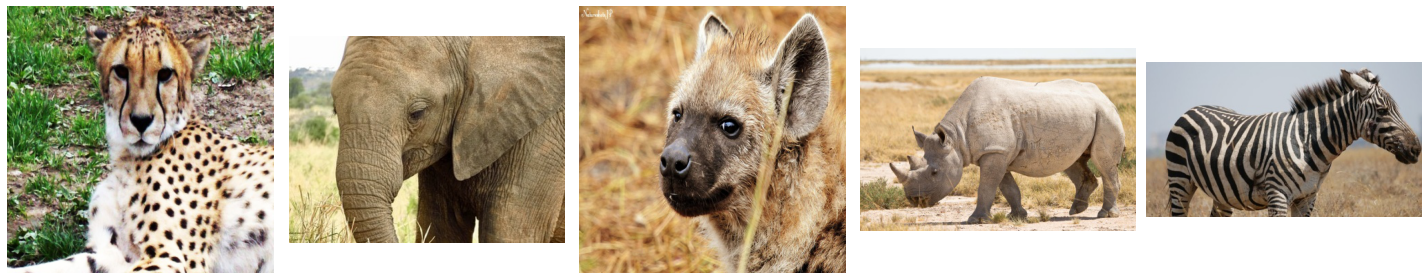

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = [
    "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data/cheetah/cheetah_005_val_resized.jpg",
    "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data/Elephant/Elephant_7.jpg",
    "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data/hyena/hyena_000_val_resized.jpg",
    "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data/Rhino/Rhino_7.jpg",
    "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data/Zebra/Zebra_13.jpg"
]

# Create a figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the image paths and display each image
for i, image_path in enumerate(image_paths):
    # Read the image file
    image = mpimg.imread(image_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [50]:
from PIL import Image

for i, image_path in enumerate(image_paths):
    image = Image.open(image_path)
    image_size = image.size
    print("Image size:", image_size)

Image size: (400, 400)
Image size: (400, 300)
Image size: (400, 400)
Image size: (400, 266)
Image size: (400, 225)


### Data Processing and Feature Engineering

Handling the class imbalance with the buffalo category after anomalies had been removed from original data file:

In [55]:
#%%
import os
import shutil

data_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data/Buffalo"

# Get the list of image files in the data folder
image_files = os.listdir(data_folder)

# Set the number of images to select and duplicate
num_images_to_select = 84
num_duplicates = 2

# Randomly select the specified number of images
selected_images = random.sample(image_files, num_images_to_select)

# Duplicate and save the selected images
for image_file in selected_images:
    # Get the source path of the image file
    source_path = os.path.join(data_folder, image_file)
    
    # Generate duplicate filenames
    for i in range(num_duplicates):
        duplicate_filename = f"duplicate_{i+1}_{image_file}"
        
        # Create the destination path for the duplicated image
        destination_path = os.path.join(data_folder, duplicate_filename)
        
        # Copy the image file to the destination path
        shutil.copyfile(source_path, destination_path)

Load and split data:

In [61]:
#%%
data_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/Data"

# Set the path to the new train, validation, and test folders
train_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/train"
val_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/validation"
test_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test"

# Set the desired ratio for train, validation, and test data (e.g., 70%, 15%, 15%)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create the train, validation, and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over each category folder in the original "Data" folder
category_folders = os.listdir(data_folder)
for category_folder in category_folders:
    # Set the path to the current category folder
    category_folder_path = os.path.join(data_folder, category_folder)
    
    # Create the corresponding train, validation, and test subfolders in the new folders
    train_category_folder = os.path.join(train_folder, category_folder)
    val_category_folder = os.path.join(val_folder, category_folder)
    test_category_folder = os.path.join(test_folder, category_folder)
    
    os.makedirs(train_category_folder, exist_ok=True)
    os.makedirs(val_category_folder, exist_ok=True)
    os.makedirs(test_category_folder, exist_ok=True)
    
    # Get the list of image files in the current category folder
    image_files = os.listdir(category_folder_path)
    
    # Shuffle the image files randomly
    random.shuffle(image_files)
    
    # Calculate the number of images for each split
    num_images = len(image_files)
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)
    num_test = int(test_ratio * num_images)
    
    # Split the image files into train, validation, and test sets
    train_images = image_files[:num_train]
    val_images = image_files[num_train:num_train+num_val]
    test_images = image_files[num_train+num_val:]
    
    # Move the images to the corresponding folders
    for image in train_images:
        source = os.path.join(category_folder_path, image)
        destination = os.path.join(train_category_folder, image)
        shutil.move(source, destination)
    
    for image in val_images:
        source = os.path.join(category_folder_path, image)
        destination = os.path.join(val_category_folder, image)
        shutil.move(source, destination)
    
    for image in test_images:
        source = os.path.join(category_folder_path, image)
        destination = os.path.join(test_category_folder, image)
        shutil.move(source, destination)


Build instances:

In [135]:
#%%
train_data_dir = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/train"
validation_data_dir = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/validation"

image_size = (200, 200)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_set = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=image_size, 
    batch_size=batch_size, 
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4800 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [64]:
train_set.image_shape

(200, 200, 3)

### Classifier Build: 

#### Baseline Model

In [136]:
#%%
classifier = Sequential()

# Add a Conv2D layer
classifier.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))

# Add a MaxPooling2D layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Add another Conv2D layer
classifier.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# Add another MaxPooling2D layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Add a Flatten layer
classifier.add(Flatten())

# Add a Dense layer
classifier.add(Dense(units=128, activation='relu'))

# Add a final Dense layer
classifier.add(Dense(units=6, activation='softmax'))

# Compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

### Fit model 

In [137]:
history = classifier.fit(train_set, epochs=10, validation_data = validation_set)

Epoch 1/10
150/150 [==============================] - 217s 1s/step - loss: 1.5280 - accuracy: 0.4573 - val_loss: 1.0608 - val_accuracy: 0.5983
Epoch 2/10
150/150 [==============================] - 238s 2s/step - loss: 1.0346 - accuracy: 0.5960 - val_loss: 1.0526 - val_accuracy: 0.6167
Epoch 3/10
150/150 [==============================] - 222s 1s/step - loss: 0.9384 - accuracy: 0.6496 - val_loss: 1.0192 - val_accuracy: 0.6383
Epoch 4/10
150/150 [==============================] - 190s 1s/step - loss: 0.8638 - accuracy: 0.6767 - val_loss: 0.9152 - val_accuracy: 0.6600
Epoch 5/10
150/150 [==============================] - 182s 1s/step - loss: 0.7648 - accuracy: 0.7156 - val_loss: 0.8218 - val_accuracy: 0.7017
Epoch 6/10
150/150 [==============================] - 192s 1s/step - loss: 0.7157 - accuracy: 0.7350 - val_loss: 0.8615 - val_accuracy: 0.6817
Epoch 7/10
150/150 [==============================] - 182s 1s/step - loss: 0.6506 - accuracy: 0.7594 - val_loss: 0.8235 - val_accuracy: 0.7167

In [138]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

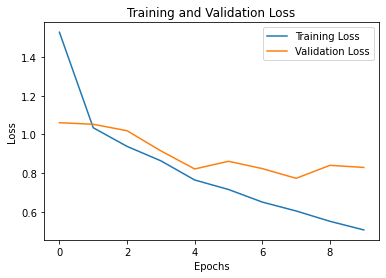

In [139]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

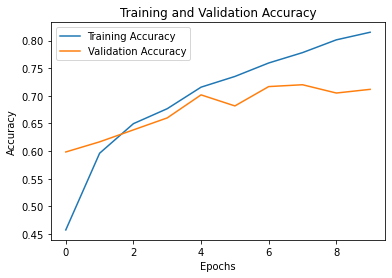

In [140]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Add a dropout layer:

In [146]:
#%%
classifier1 = Sequential()
classifier1.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))
classifier1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))
classifier1.add(Flatten())
classifier1.add(Dropout(0.3))
classifier1.add(Dense(units=128, activation='relu'))
classifier1.add(Dense(units=6, activation='softmax'))
classifier1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [147]:
history1 = classifier1.fit(train_set, epochs=10, validation_data = validation_set)

Epoch 1/10
150/150 [==============================] - 186s 1s/step - loss: 1.6288 - accuracy: 0.4137 - val_loss: 1.1845 - val_accuracy: 0.5617
Epoch 2/10
150/150 [==============================] - 185s 1s/step - loss: 1.0434 - accuracy: 0.6077 - val_loss: 0.9747 - val_accuracy: 0.6567
Epoch 3/10
150/150 [==============================] - 192s 1s/step - loss: 0.9038 - accuracy: 0.6687 - val_loss: 0.8607 - val_accuracy: 0.6900
Epoch 4/10
150/150 [==============================] - 182s 1s/step - loss: 0.8167 - accuracy: 0.7044 - val_loss: 0.7039 - val_accuracy: 0.7617
Epoch 5/10
150/150 [==============================] - 215s 1s/step - loss: 0.7205 - accuracy: 0.7377 - val_loss: 0.7046 - val_accuracy: 0.7417
Epoch 6/10
150/150 [==============================] - 186s 1s/step - loss: 0.6515 - accuracy: 0.7652 - val_loss: 0.7197 - val_accuracy: 0.7600
Epoch 7/10
150/150 [==============================] - 184s 1s/step - loss: 0.5950 - accuracy: 0.7835 - val_loss: 0.6574 - val_accuracy: 0.7617

In [148]:
classifier1.save('model1.h5')
print("Saved model")
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
train_acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

Saved model


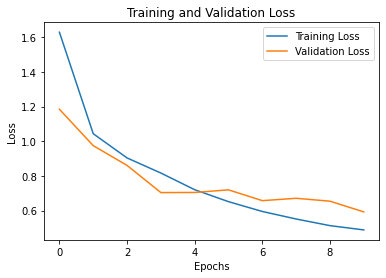

In [149]:
plt.plot(train_loss1, label='Training Loss')
plt.plot(val_loss1, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

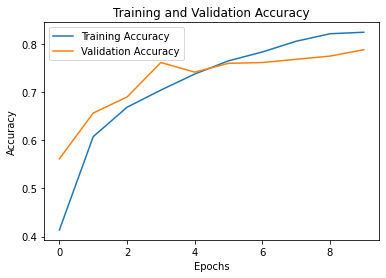

In [150]:
plt.plot(train_acc1, label='Training Accuracy')
plt.plot(val_acc1, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Set up the test dataset with correct labels:

In [120]:
#%%
test_data_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test"
combined_folder = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1"

# Create the combined folder if it doesn't exist
if not os.path.exists(combined_folder):
    os.makedirs(combined_folder)

# List to store the image filenames and their corresponding labels
combined_images = []

# Iterate over each category folder
for category_folder in os.listdir(test_data_folder):
    category_path = os.path.join(test_data_folder, category_folder)
    
    # Iterate over the image files in the category folder
    for image_file in os.listdir(category_path):
        source_path = os.path.join(category_path, image_file)
        destination_path = os.path.join(combined_folder, image_file)
        
        # Copy the image file to the combined folder
        shutil.copyfile(source_path, destination_path)
        
        # Store the image filename and its label
        combined_images.append((image_file, category_folder))
        
# Shuffle the combined images list
random.shuffle(combined_images)

shuffled_labels = []

# Iterate over the shuffled list and rename the image files
for i, (image_file, label) in enumerate(combined_images):
    old_path = os.path.join(combined_folder, image_file)
    new_filename = f'image_{i}.jpg'  # Rename with sequential numbers
    new_path = os.path.join(combined_folder, new_filename)
    
    os.rename(old_path, new_path)
    
    # Add the correct label to the shuffled labels list
    shuffled_labels.append(label)

print(shuffled_labels)
#{'Buffalo': 0, 'Elephant': 1, 'Rhino': 2, 'Zebra': 3, 'cheetah': 4, 'hyena': 5}

test_labels=[]
for i in range(len(shuffled_labels)):
    if shuffled_labels[i] == 'Buffalo':
        test_labels.append(0)
    elif shuffled_labels[i] == 'Elephant':
        test_labels.append(1)
    elif shuffled_labels[i] == 'Rhino':
        test_labels.append(2)
    elif shuffled_labels[i] == 'Zebra':
        test_labels.append(3)
    elif shuffled_labels[i] == 'cheetah':
        test_labels.append(4)
    elif shuffled_labels[i] == 'hyena':
        test_labels.append(5)

# Print the updated list
print(test_labels)

['hyena', 'Rhino', 'Elephant', 'Elephant', 'Buffalo', 'Elephant', 'Rhino', 'Rhino', 'Rhino', 'hyena', 'Rhino', 'Zebra', 'Zebra', 'hyena', 'cheetah', 'Rhino', 'cheetah', 'hyena', 'Buffalo', 'hyena', 'Rhino', 'Rhino', 'Elephant', 'cheetah', 'Elephant', 'Elephant', 'Rhino', 'cheetah', 'Rhino', 'hyena', 'hyena', 'Buffalo', 'Buffalo', 'hyena', 'Rhino', 'Zebra', 'Buffalo', 'hyena', 'Zebra', 'Buffalo', 'Elephant', 'Buffalo', 'Rhino', 'hyena', 'Zebra', 'hyena', 'Rhino', 'Rhino', 'Buffalo', 'Elephant', 'Buffalo', 'Buffalo', 'hyena', 'Elephant', 'hyena', 'Buffalo', 'Rhino', 'Buffalo', 'hyena', 'Rhino', 'Zebra', 'Elephant', 'Buffalo', 'Rhino', 'Zebra', 'Elephant', 'cheetah', 'Buffalo', 'Elephant', 'Rhino', 'hyena', 'Buffalo', 'Elephant', 'Elephant', 'cheetah', 'Elephant', 'Rhino', 'Buffalo', 'Buffalo', 'cheetah', 'hyena', 'Zebra', 'Elephant', 'hyena', 'Elephant', 'hyena', 'cheetah', 'Buffalo', 'cheetah', 'Rhino', 'hyena', 'hyena', 'cheetah', 'cheetah', 'Elephant', 'Buffalo', 'Buffalo', 'hyena', '

### Predict using model1

In [154]:
model1 = load_model('model1.h5')
print("Loaded model 1 from disk")

test_data_dir = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1"

# iterate over each test image
#data_path = os.path.join(test_data_dir, '*g')
file_names = os.listdir(test_data_dir)

sorted_files = sorted(file_names, key=lambda x: int(x.split('_')[1].split('.')[0]))

# make a prediction and add to results 
data1 = []
results1 = []

for file_name in sorted_files:
    file_path = os.path.join(test_data_dir, file_name)
    # Process the file
    #print(file_path)

    img = image.load_img(file_path, target_size = (200, 200))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    data1.append(img)
    result1 = model1.predict(img)
    r1 = np.argmax(result1, axis=1)
    results1.append(r1)

print(results1)

Loaded model 1 from disk
1/1 [==============================] - 0s 38ms/step
[array([5], dtype=int64), array([5], dtype=int64), array([1], dtype=int64), array([3], dtype=int64), array([0], dtype=int64), array([5], dtype=int64), array([5], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([5], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([2], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([2], dtype=int64), array([4], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([5], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([0], dtype=int64

In [179]:
accuracy1 = accuracy_score(test_labels, results1)

print("Overall Test Accuracy:", accuracy1)

categories = set(test_labels)
category_accuracies1 = []
for category in categories:
    category_indices = [i for i, label in enumerate(test_labels) if label == category]
    category_true_labels = [test_labels[i] for i in category_indices]
    category_predicted_labels = [results1[i][0] for i in category_indices]

    # Calculate accuracy for the category
    category_accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    category_accuracies1.append(category_accuracy)
    print(f"Accuracy for Category {category}: {category_accuracy}")
    
#{'Buffalo': 0, 'Elephant': 1, 'Rhino': 2, 'Zebra': 3, 'cheetah': 4, 'hyena': 5}
print(category_accuracies1)

Overall Test Accuracy: 0.6716666666666666
Accuracy for Category 0: 0.6
Accuracy for Category 1: 0.57
Accuracy for Category 2: 0.52
Accuracy for Category 3: 0.98
Accuracy for Category 4: 0.91
Accuracy for Category 5: 0.45
[0.6, 0.57, 0.52, 0.98, 0.91, 0.45]


#### Results from model 1 not too bad
- Can identify zebras (0.98) and cheetahs (0.91) very well
- Accuracy for zebras agrees with hypothesis mentioned in the beginning of project
- Only around 7,000 cheetahs are alive today, making them the most endangered big cat (so it's important to be able to correcltly classify them)

### Same model, but experiment with different epochs

In [97]:
from keras.callbacks import EarlyStopping

In [157]:
#%%
classifier2 = Sequential()
classifier2.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))
classifier2.add(MaxPooling2D(pool_size=(2,2)))
classifier2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier2.add(MaxPooling2D(pool_size=(2,2)))
classifier2.add(Flatten())
classifier2.add(Dropout(0.3))
classifier2.add(Dense(units=128, activation='relu'))
classifier2.add(Dense(units=6, activation='softmax'))
classifier2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [158]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Train the model with early stopping
history2 = classifier2.fit(train_set, epochs=30, validation_data = validation_set, callbacks=[early_stopping])

Epoch 1/30
150/150 [==============================] - 186s 1s/step - loss: 1.5677 - accuracy: 0.4548 - val_loss: 1.0310 - val_accuracy: 0.6083
Epoch 2/30
150/150 [==============================] - 178s 1s/step - loss: 1.0130 - accuracy: 0.6181 - val_loss: 0.8819 - val_accuracy: 0.6650
Epoch 3/30
150/150 [==============================] - 185s 1s/step - loss: 0.9090 - accuracy: 0.6652 - val_loss: 0.8706 - val_accuracy: 0.6850
Epoch 4/30
150/150 [==============================] - 165s 1s/step - loss: 0.8134 - accuracy: 0.7006 - val_loss: 0.7715 - val_accuracy: 0.7283
Epoch 5/30
150/150 [==============================] - 172s 1s/step - loss: 0.7322 - accuracy: 0.7319 - val_loss: 0.6490 - val_accuracy: 0.7567
Epoch 6/30
150/150 [==============================] - 169s 1s/step - loss: 0.6721 - accuracy: 0.7619 - val_loss: 0.8014 - val_accuracy: 0.7183
Epoch 7/30
150/150 [==============================] - 165s 1s/step - loss: 0.6208 - accuracy: 0.7713 - val_loss: 0.6931 - val_accuracy: 0.7500

### Add more layers

In [159]:
#%%
classifier3 = Sequential()
classifier3.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))
classifier3.add(MaxPooling2D(pool_size=(2,2)))
classifier3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier3.add(MaxPooling2D(pool_size=(2,2)))
classifier3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
classifier3.add(MaxPooling2D(pool_size=(2,2)))
classifier3.add(Flatten())
classifier3.add(Dropout(0.3))
classifier3.add(Dense(units=128, activation='relu'))
classifier3.add(Dense(units=256, activation='relu'))
classifier3.add(Dense(units=6, activation='softmax'))
classifier3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [160]:
history3 = classifier3.fit(train_set, epochs=10, validation_data = validation_set)

Epoch 1/10
150/150 [==============================] - 198s 1s/step - loss: 1.4696 - accuracy: 0.4060 - val_loss: 1.1276 - val_accuracy: 0.5400
Epoch 2/10
150/150 [==============================] - 194s 1s/step - loss: 1.0337 - accuracy: 0.6019 - val_loss: 0.9940 - val_accuracy: 0.6133
Epoch 3/10
150/150 [==============================] - 199s 1s/step - loss: 0.8528 - accuracy: 0.6783 - val_loss: 0.7878 - val_accuracy: 0.6983
Epoch 4/10
150/150 [==============================] - 192s 1s/step - loss: 0.7846 - accuracy: 0.7115 - val_loss: 0.7000 - val_accuracy: 0.7600
Epoch 5/10
150/150 [==============================] - 193s 1s/step - loss: 0.6784 - accuracy: 0.7504 - val_loss: 0.7095 - val_accuracy: 0.7467
Epoch 6/10
150/150 [==============================] - 202s 1s/step - loss: 0.6034 - accuracy: 0.7837 - val_loss: 0.5855 - val_accuracy: 0.7783
Epoch 7/10
150/150 [==============================] - 191s 1s/step - loss: 0.5394 - accuracy: 0.8037 - val_loss: 0.6076 - val_accuracy: 0.7817

### Try more epochs

In [161]:
#%%
classifier4 = Sequential()
classifier4.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))
classifier4.add(MaxPooling2D(pool_size=(2,2)))
classifier4.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier4.add(MaxPooling2D(pool_size=(2,2)))
classifier4.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
classifier4.add(MaxPooling2D(pool_size=(2,2)))
classifier4.add(Flatten())
classifier4.add(Dropout(0.3))
classifier4.add(Dense(units=128, activation='relu'))
classifier4.add(Dense(units=256, activation='relu'))
classifier4.add(Dense(units=6, activation='softmax'))
classifier4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history4 = classifier4.fit(train_set, epochs=20, validation_data = validation_set)

Epoch 1/20
150/150 [==============================] - 192s 1s/step - loss: 1.3710 - accuracy: 0.4360 - val_loss: 1.2153 - val_accuracy: 0.5500
Epoch 2/20
150/150 [==============================] - 190s 1s/step - loss: 0.9980 - accuracy: 0.6190 - val_loss: 1.0204 - val_accuracy: 0.6300
Epoch 3/20
150/150 [==============================] - 193s 1s/step - loss: 0.8354 - accuracy: 0.6925 - val_loss: 0.7656 - val_accuracy: 0.7283
Epoch 4/20
150/150 [==============================] - 191s 1s/step - loss: 0.7273 - accuracy: 0.7329 - val_loss: 0.6732 - val_accuracy: 0.7617
Epoch 5/20
150/150 [==============================] - 190s 1s/step - loss: 0.6542 - accuracy: 0.7633 - val_loss: 0.5766 - val_accuracy: 0.7967
Epoch 6/20
150/150 [==============================] - 191s 1s/step - loss: 0.5513 - accuracy: 0.7965 - val_loss: 0.6455 - val_accuracy: 0.7900
Epoch 7/20
150/150 [==============================] - 192s 1s/step - loss: 0.4896 - accuracy: 0.8248 - val_loss: 0.6840 - val_accuracy: 0.7750

In [162]:
classifier4.save('model4.h5')
print("Saved model")
train_loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
train_acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']

Saved model


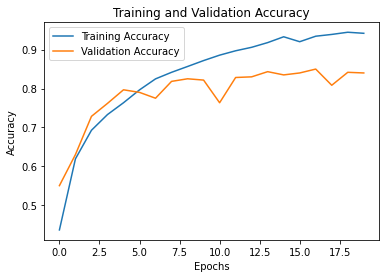

In [163]:
plt.plot(train_acc4, label='Training Accuracy')
plt.plot(val_acc4, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [164]:
model4 = load_model('model4.h5')
print("Loaded model 4 from disk")

test_data_dir = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1"

# iterate over each test image
#data_path = os.path.join(test_data_dir, '*g')
file_names = os.listdir(test_data_dir)

sorted_files = sorted(file_names, key=lambda x: int(x.split('_')[1].split('.')[0]))

# make a prediction and add to results 
data4 = []
results4 = []

for file_name in sorted_files:
    file_path = os.path.join(test_data_dir, file_name)
    # Process the file
    #print(file_path)

    img = image.load_img(file_path, target_size = (200, 200))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    data4.append(img)
    result4 = model4.predict(img)
    r4 = np.argmax(result4, axis=1)
    results4.append(r4)

print(results4)

Loaded model 4 from disk
1/1 [==============================] - 0s 32ms/step
[array([3], dtype=int64), array([5], dtype=int64), array([1], dtype=int64), array([3], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([2], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([5], dtype=int64), array([0], dtype=int64), array([4], dtype=int64), array([5], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([1], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([2], dtype=int64), array([4], dtype=int64), array([0], dtype=int64), array([5], dtype=int64), array([4], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([0], dtype=int64

In [165]:
accuracy4 = accuracy_score(test_labels, results4)

print("Overall Test Accuracy:", accuracy4)

categories = set(test_labels)
for category in categories:
    category_indices = [i for i, label in enumerate(test_labels) if label == category]
    category_true_labels = [test_labels[i] for i in category_indices]
    category_predicted_labels = [results4[i][0] for i in category_indices]

    # Calculate accuracy for the category
    category_accuracy = accuracy_score(category_true_labels, category_predicted_labels)

    print(f"Accuracy for Category {category}: {category_accuracy}")
    
#{'Buffalo': 0, 'Elephant': 1, 'Rhino': 2, 'Zebra': 3, 'cheetah': 4, 'hyena': 5}

Overall Test Accuracy: 0.6533333333333333
Accuracy for Category 0: 0.63
Accuracy for Category 1: 0.6
Accuracy for Category 2: 0.4
Accuracy for Category 3: 0.98
Accuracy for Category 4: 0.96
Accuracy for Category 5: 0.35


### Trying adding Batch Normalization layers:

In [167]:
#%%
classifier5 = Sequential()
classifier5.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))
classifier5.add(BatchNormalization()) 
classifier5.add(MaxPooling2D(pool_size=(2,2)))
classifier5.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier5.add(BatchNormalization()) 
classifier5.add(MaxPooling2D(pool_size=(2,2)))
classifier5.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
classifier5.add(MaxPooling2D(pool_size=(2,2)))
classifier5.add(Flatten())
classifier5.add(Dropout(0.3))
classifier5.add(Dense(units=128, activation='relu'))
classifier5.add(Dense(units=256, activation='relu'))
classifier5.add(Dense(units=6, activation='softmax'))
classifier5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history5 = classifier5.fit(train_set, epochs=17, validation_data = validation_set)

Epoch 1/17
150/150 [==============================] - 335s 2s/step - loss: 2.1766 - accuracy: 0.3900 - val_loss: 1.8230 - val_accuracy: 0.1667
Epoch 2/17
150/150 [==============================] - 240s 2s/step - loss: 1.0476 - accuracy: 0.5983 - val_loss: 1.6237 - val_accuracy: 0.2900
Epoch 3/17
150/150 [==============================] - 242s 2s/step - loss: 0.8727 - accuracy: 0.6706 - val_loss: 1.7672 - val_accuracy: 0.4750
Epoch 4/17
150/150 [==============================] - 251s 2s/step - loss: 0.7687 - accuracy: 0.7108 - val_loss: 0.9609 - val_accuracy: 0.6617
Epoch 5/17
150/150 [==============================] - 262s 2s/step - loss: 0.6558 - accuracy: 0.7658 - val_loss: 1.2359 - val_accuracy: 0.6633
Epoch 6/17
150/150 [==============================] - 247s 2s/step - loss: 0.5937 - accuracy: 0.7896 - val_loss: 1.7129 - val_accuracy: 0.6383
Epoch 7/17
150/150 [==============================] - 260s 2s/step - loss: 0.5409 - accuracy: 0.8035 - val_loss: 0.8591 - val_accuracy: 0.6800

#### Try adding more convolutional and pooling layers instead 
Batch normalization didn't really do much

In [169]:
classifier6 = Sequential()
classifier6.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu'))
classifier6.add(MaxPooling2D(pool_size=(2,2)))
classifier6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier6.add(MaxPooling2D(pool_size=(2,2)))
classifier6.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
classifier6.add(MaxPooling2D(pool_size=(2,2)))
classifier6.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
classifier6.add(MaxPooling2D(pool_size=(2,2)))
classifier6.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
classifier6.add(MaxPooling2D(pool_size=(2,2)))
classifier6.add(Flatten())
classifier6.add(Dropout(0.3))
classifier6.add(Dense(units=128, activation='relu'))
classifier6.add(Dense(units=256, activation='relu'))
classifier6.add(Dense(units=6, activation='softmax'))
classifier6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history6 = classifier6.fit(train_set, epochs=14, validation_data = validation_set)

Epoch 1/14
150/150 [==============================] - 236s 2s/step - loss: 1.5118 - accuracy: 0.3510 - val_loss: 1.1721 - val_accuracy: 0.4833
Epoch 2/14
150/150 [==============================] - 238s 2s/step - loss: 1.1436 - accuracy: 0.5185 - val_loss: 0.9712 - val_accuracy: 0.5817
Epoch 3/14
150/150 [==============================] - 233s 2s/step - loss: 1.0098 - accuracy: 0.5948 - val_loss: 0.9094 - val_accuracy: 0.6367
Epoch 4/14
150/150 [==============================] - 254s 2s/step - loss: 0.9012 - accuracy: 0.6531 - val_loss: 0.8063 - val_accuracy: 0.6783
Epoch 5/14
150/150 [==============================] - 251s 2s/step - loss: 0.7569 - accuracy: 0.7231 - val_loss: 0.7120 - val_accuracy: 0.7267
Epoch 6/14
150/150 [==============================] - 242s 2s/step - loss: 0.6606 - accuracy: 0.7596 - val_loss: 0.6678 - val_accuracy: 0.7450
Epoch 7/14
150/150 [==============================] - 238s 2s/step - loss: 0.6018 - accuracy: 0.7846 - val_loss: 0.6355 - val_accuracy: 0.7750

In [170]:
train_loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']
train_acc6 = history6.history['accuracy']
val_acc6 = history6.history['val_accuracy']

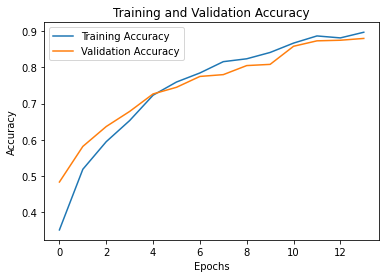

In [171]:
plt.plot(train_acc6, label='Training Accuracy')
plt.plot(val_acc6, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

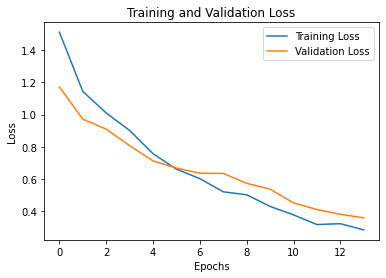

In [172]:
plt.plot(train_loss6, label='Training Loss')
plt.plot(val_loss6, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

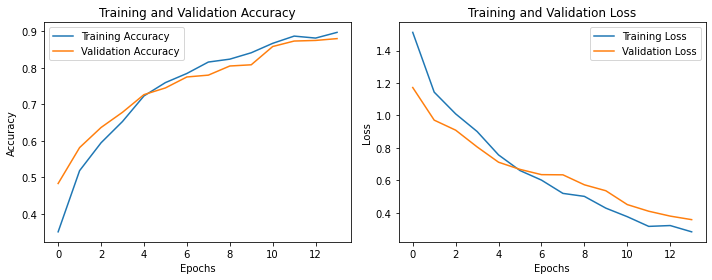

In [196]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot on the first subplot
ax1.plot(train_acc6, label='Training Accuracy')
ax1.plot(val_acc6, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot on the second subplot
ax2.plot(train_loss6, label='Training Loss')
ax2.plot(val_loss6, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Save model to a file:

In [173]:
classifier6.save('model6.h5')
print("Saved model")

Saved model


#### Predict and find test accuracies

In [174]:
model6 = load_model('model6.h5')
print("Loaded model 6 from disk")

test_data_dir = "C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1"

# iterate over each test image
#data_path = os.path.join(test_data_dir, '*g')
file_names = os.listdir(test_data_dir)

sorted_files = sorted(file_names, key=lambda x: int(x.split('_')[1].split('.')[0]))

# make a prediction and add to results 
data6 = []
results6 = []

for file_name in sorted_files:
    file_path = os.path.join(test_data_dir, file_name)
    # Process the file
    print(file_path)

    img = image.load_img(file_path, target_size = (200, 200))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    data6.append(img)
    result6 = model6.predict(img)
    r6 = np.argmax(result6, axis=1)
    results6.append(r6)

print(results6)

Loaded model 6 from disk
C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1\image_0.jpg
1/1 [==============================] - 0s 114ms/step
C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1\image_1.jpg
1/1 [==============================] - 0s 34ms/step
C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1\image_2.jpg
1/1 [==============================] - 0s 40ms/step
C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1\image_3.jpg
1/1 [==============================] - 0s 28ms/step
C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1\image_4.jpg
1/1 [==============================] - 0s 29ms/step
C:/Users/sundu/OneDrive - The University of Chicago/Documents/Spring 2023/Machine Learning/test1\image_5.jpg
1/1 [==============================] - 0s 37ms/step
C:/Users

In [180]:
accuracy6 = accuracy_score(test_labels, results6)

print("Overall Test Accuracy:", accuracy6)
category_accuracies6 = []
categories = set(test_labels)
for category in categories:
    category_indices = [i for i, label in enumerate(test_labels) if label == category]
    category_true_labels = [test_labels[i] for i in category_indices]
    category_predicted_labels = [results6[i][0] for i in category_indices]

    # Calculate accuracy for the category
    category_accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    category_accuracies6.append(category_accuracy)
    print(f"Accuracy for Category {category}: {category_accuracy}")
    
#{'Buffalo': 0, 'Elephant': 1, 'Rhino': 2, 'Zebra': 3, 'cheetah': 4, 'hyena': 5}

Overall Test Accuracy: 0.735
Accuracy for Category 0: 0.61
Accuracy for Category 1: 0.78
Accuracy for Category 2: 0.76
Accuracy for Category 3: 1.0
Accuracy for Category 4: 0.92
Accuracy for Category 5: 0.34


In [177]:
print("Classification Report:")
print(classification_report(test_labels, results6))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       100
           1       0.59      0.78      0.67       100
           2       0.66      0.76      0.71       100
           3       0.74      1.00      0.85       100
           4       0.87      0.92      0.89       100
           5       0.87      0.34      0.49       100

    accuracy                           0.73       600
   macro avg       0.76      0.73      0.72       600
weighted avg       0.76      0.73      0.72       600



Create a dataframe that combines the accuracy across the different classifiers built above

In [193]:
data = {
    'Training Accuracy': [train_acc1[9], train_acc6[13]],
    'Validation Accuracy': [val_acc1[9], val_acc6[13]],
    'Overall Test Accuracy': [accuracy1, accuracy6],
    'Category 0 "Buffalo" Accuracy': [category_accuracies1[0], category_accuracies6[0]],
    'Category 1 "Elephant" Accuracy': [category_accuracies1[1], category_accuracies6[1]],
    'Category 2 "Rhino" Accuracy': [category_accuracies1[2], category_accuracies6[2]],
    'Category 3 "Zebra" Accuracy': [category_accuracies1[3], category_accuracies6[3]],
    'Category 4 "Cheetah" Accuracy': [category_accuracies1[4], category_accuracies6[4]],
    'Category 5 "Hyena" Accuracy': [category_accuracies1[5], category_accuracies6[5]]
}

# Create a DataFrame from the data
df = pd.DataFrame(data, index = ['Baseline', 'Final'])
df.T

,Baseline,Final
Training Accuracy,0.824583,0.897083
Validation Accuracy,0.788333,0.880000
Overall Test Accuracy,0.671667,0.735000
"Category 0 ""Buffalo"" Accuracy",0.600000,0.610000
"Category 1 ""Elephant"" Accuracy",0.570000,0.780000
"Category 2 ""Rhino"" Accuracy",0.520000,0.760000
"Category 3 ""Zebra"" Accuracy",0.980000,1.000000
"Category 4 ""Cheetah"" Accuracy",0.910000,0.920000
"Category 5 ""Hyena"" Accuracy",0.450000,0.340000
